In [1]:
import os
import cv2
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image

In [2]:
# Function to load the MSTAR dataset and resize to 128 * 128
def get_MSTAR(train_dir, val_dir, test_dir):
    def load_images_from_folder(folder):
        images = []
        labels = []
        file_paths = []  # New list to store file paths
        for label in os.listdir(folder):
            label_folder = os.path.join(folder, label)
            if os.path.isdir(label_folder):
                for filename in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Resize image to 128x128
                        img_resized = cv2.resize(img, (128, 128))
                        images.append(img_resized)
                        labels.append(label)
                        file_paths.append(img_path)  # Store the file path
        return np.array(images), np.array(labels), file_paths  # Return file paths as well

    X_train, y_train, train_paths = load_images_from_folder(train_dir)
    X_val, y_val, val_paths = load_images_from_folder(val_dir)
    X_test, y_test, test_paths = load_images_from_folder(test_dir)
    
    return X_train, y_train, train_paths, X_val, y_val, val_paths, X_test, y_test, test_paths

# Function to display trained, validated, and tested sets
def display_class_counts(y_train, y_val, y_test):
    train_counts = Counter(y_train)
    val_counts = Counter(y_val)
    test_counts = Counter(y_test)
    classes = sorted(set(train_counts.keys()).union(set(val_counts.keys()).union(set(test_counts.keys()))))
    print(f"{'Class':<10} {'Train Count':<12} {'Val Count':<12} {'Test Count':<10}")
    print("="*44)
    for cls in classes:
        train_count = train_counts.get(cls, 0)
        val_count = val_counts.get(cls, 0)
        test_count = test_counts.get(cls, 0)
        print(f"{cls:<10} {train_count:<12} {val_count:<12} {test_count:<10}")

In [3]:
# Path to the training, validation, and testing datasets
train_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TRAIN'
val_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/VAL'  # Add the path to your validation folder
test_dir = '/home/nathan/Documents/EEE4022S/New/DATASET/TEST'

In [4]:
# Dataset loading
X_train, y_train, train_paths, X_val, y_val, val_paths, X_test, y_test, test_paths = get_MSTAR(train_dir, val_dir, test_dir)
display_class_counts(y_train, y_val, y_test)

Class      Train Count  Val Count    Test Count
2S1        230          80           141       
BRDM_2     230          80           141       
BTR_60     230          80           141       
D7         230          80           141       
SLICY      230          80           141       
T62        230          80           141       
ZIL131     230          80           141       
ZSU_23_4   230          80           141       


In [5]:
def flatten_images(images):
    return np.array([img.flatten() for img in images])

X_train_flat = flatten_images(X_train)
X_val_flat = flatten_images(X_val)
X_test_flat = flatten_images(X_test)

# Standardize data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

def plot_pca_explained_variance(pca):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

def plot_scree(pca):
    plt.figure(figsize=(8, 4))
    plt.plot(pca.explained_variance_, marker='o', linestyle='--')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()

def plot_biplot(pca, X, labels):
    pca_components = pca.components_.T
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
    for i, (x, y) in enumerate(pca_components):
        plt.arrow(0, 0, x*max(X[:, 0]), y*max(X[:, 1]), head_width=0.1, head_length=0.1, fc='red', ec='red')
        plt.text(x*max(X[:, 0]), y*max(X[:, 1]), f'PC{i+1}', color='red')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('PCA Biplot')
    plt.grid(True)
    plt.show()

In [6]:
# Perform PCA on the flattened training data
pca = PCA(n_components=20)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train_flat)
X_val_pca = pca.transform(X_val_flat)
X_test_pca = pca.transform(X_test_flat)
X_train_pca.shape

(1840, 20)

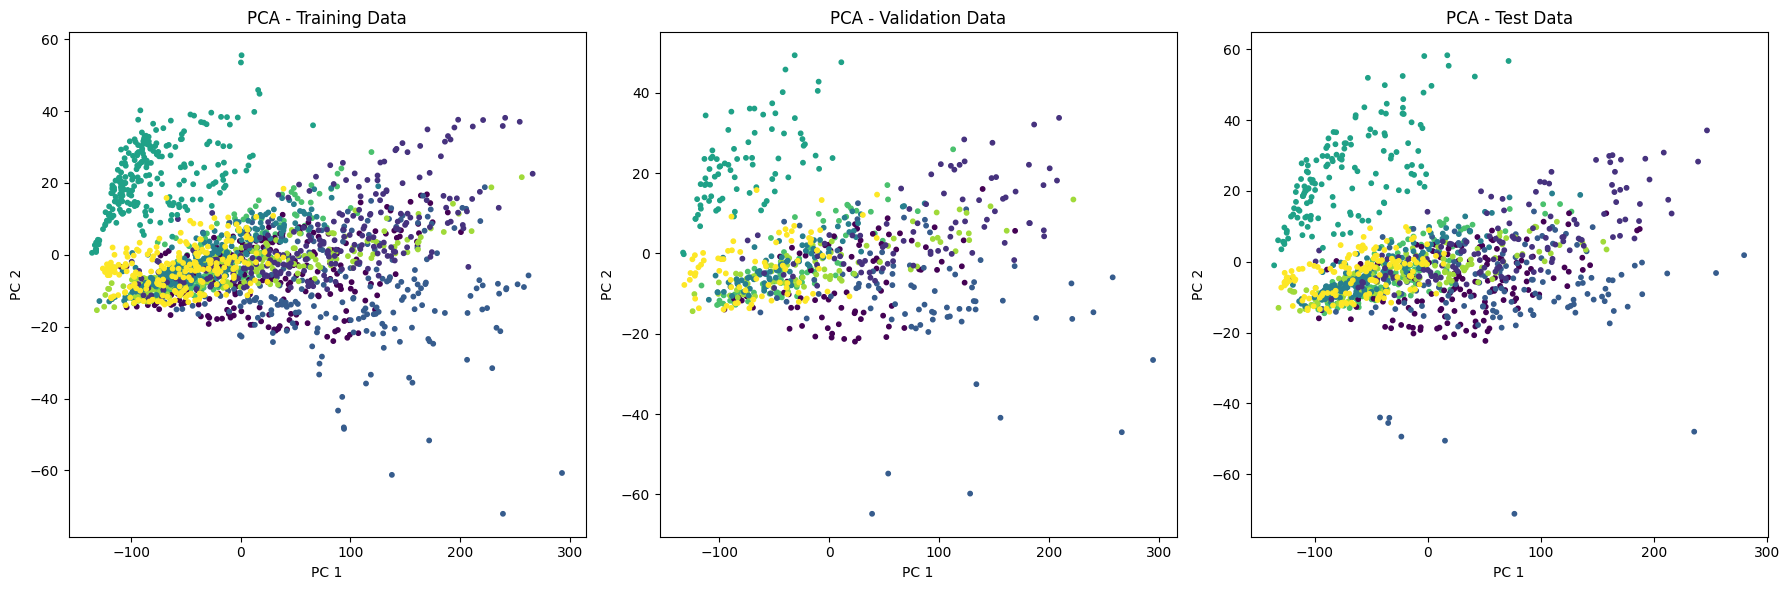

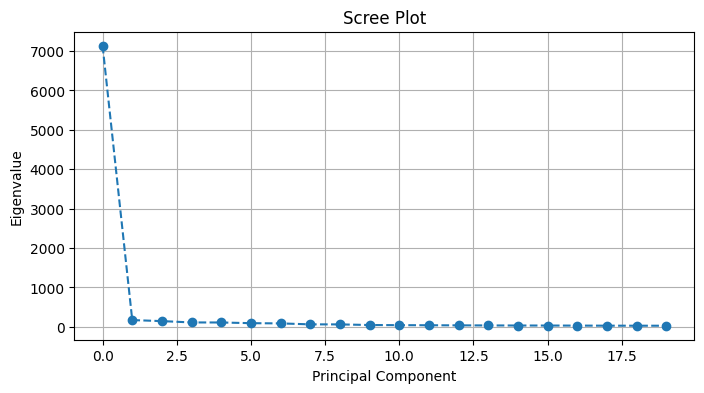

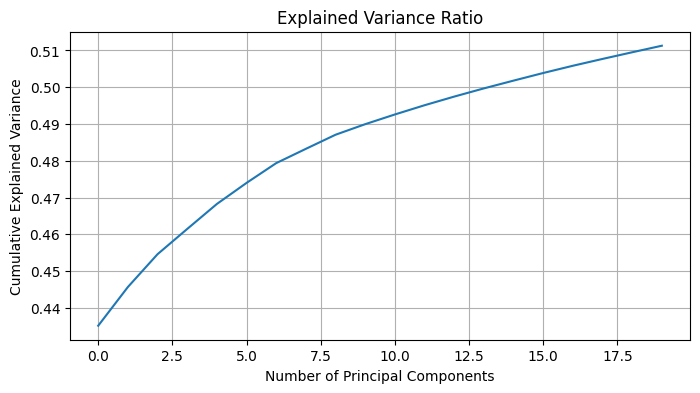

In [7]:
# Plot PCA results (training, validation, and test data)
plt.figure(figsize=(18, 6))
# PCA on Training Data
plt.subplot(1, 3, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=LabelEncoder().fit_transform(y_train), cmap='viridis', s=10)
plt.title('PCA - Training Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# PCA on Validation Data
plt.subplot(1, 3, 2)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c=LabelEncoder().fit_transform(y_val), cmap='viridis', s=10)
plt.title('PCA - Validation Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# PCA on Test Data
plt.subplot(1, 3, 3)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=LabelEncoder().fit_transform(y_test), cmap='viridis', s=10)
plt.title('PCA - Test Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.show()

# Scree plot
plot_scree(pca)
# Plot explained variance ratio
plot_pca_explained_variance(pca)

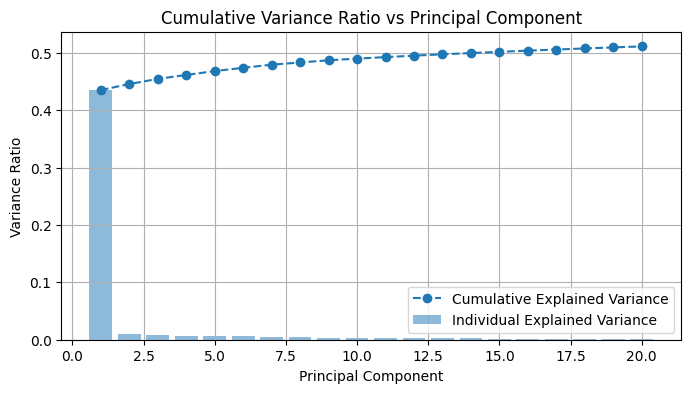

In [8]:
def plot_cumulative_variance_ratio(pca):
    plt.figure(figsize=(8, 4))
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, label='Individual Explained Variance')
    
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Ratio')
    plt.title('Cumulative Variance Ratio vs Principal Component')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot cumulative variance ratio
plot_cumulative_variance_ratio(pca)

In [9]:
def visualize_pca_image(original_image, pca_components, pca_image, index):
    # Reshape the original and reconstructed images
    original_reshaped = original_image.reshape(128, 128)
    reconstructed = pca.inverse_transform(pca_image).reshape(128, 128)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    ax1.imshow(original_reshaped, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Display the reconstructed image
    ax2.imshow(reconstructed, cmap='gray')
    ax2.set_title(f'Reconstructed Image (PCA: {pca_components} components)')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

Path of the first image in the training set: /home/nathan/Documents/EEE4022S/New/DATASET/TRAIN/T62/HB19877.JPG


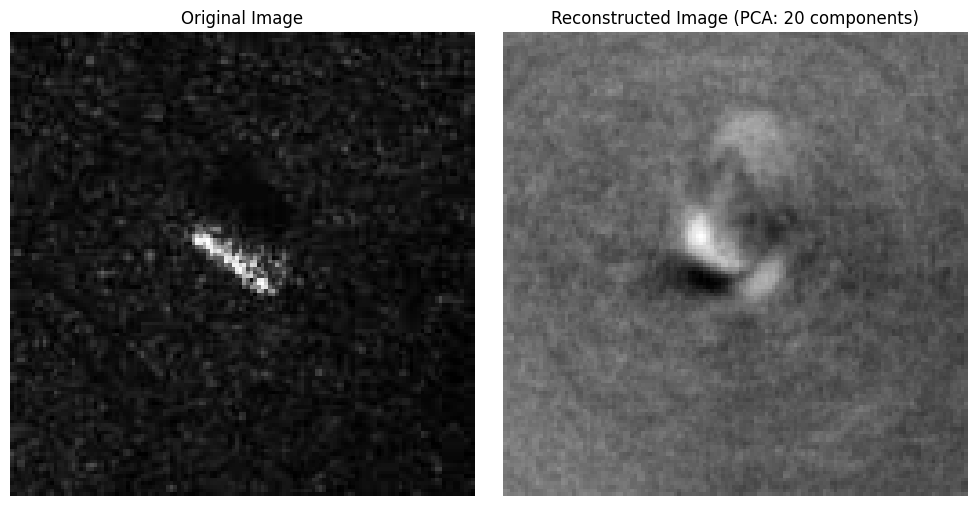

In [10]:
# Choose an index to visualize (e.g., the first image)
index_to_visualize = 20
path_of_index_0 = train_paths[index_to_visualize]
print(f"Path of the first image in the training set: {path_of_index_0}")

# Visualize the image
visualize_pca_image(X_train[index_to_visualize], 
                    pca.n_components_, 
                    X_train_pca[index_to_visualize], 
                    index_to_visualize)
